In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

import seaborn as sns
import matplotlib.pyplot as plt     

In [2]:
metadata = pd.read_csv("../../BODMAS leaderboard/BODMAS/bodmas_metadata.csv")
metadata['family'] = metadata['family'].fillna('benign')

bucket_data = pd.read_csv("../../BODMAS leaderboard/BODMAS/bodmas_malware_category.csv")
bucket_data = bucket_data.rename(columns={'sha256': 'sha'})

data = np.load('../../BODMAS leaderboard/BODMAS/bodmas.npz')
X = data['X']
y = data['y']

temp = pd.merge(metadata, bucket_data[["sha","category"]], on="sha",how="left")
temp['category'] = temp['category'].fillna('benign')

j = 0
label_dict = {}
for k,i in temp.iloc[:,-1].value_counts().items():
    label_dict[k] = j
    j += 1

def label_mapper(r,info=label_dict):
    return info[r] 
temp['Label'] = [label_mapper(x) for x in temp['category']]
labels_df = temp.copy()
labels = list(labels_df['Label'])

col_names = ['col' + str(i) for i in np.arange(X.shape[1]) + 1]
temp = pd.DataFrame(data=X, columns=col_names)
temp['label'] = labels

finaldf = temp.copy()
finaldf.shape

(134435, 2382)

In [3]:
label_mapper

<function __main__.label_mapper(r, info={'benign': 0, 'trojan': 1, 'worm': 2, 'backdoor': 3, 'downloader': 4, 'ransomware': 5, 'dropper': 6, 'informationstealer': 7, 'virus': 8, 'pua': 9, 'cryptominer': 10, 'p2p-worm': 11, 'exploit': 12, 'trojan-gamethief': 13, 'rootkit': 14})>

In [4]:
df = finaldf
df.label.value_counts()

0     77142
1     29972
2     16697
3      7331
4      1031
5       821
6       715
7       448
8       192
9        29
10       20
11       16
12       12
13        6
14        3
Name: label, dtype: int64

In [5]:
LEARNING_RATE = 0.001
EPOCHS = 5
BATCH_SIZE = 64
BUFFER_SIZE = int(BATCH_SIZE * 10)
NON_ZERO_DAY_CLASSES = [0,1,3,4,7,9,11]

In [6]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.mean(),inplace=True)

df_ = df[df.label.isin(NON_ZERO_DAY_CLASSES)]

X = df_.iloc[:,:-1]
y = df_.iloc[:,-1]
y[y!=0] = 1
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=128)

zero = df[~df.label.isin(NON_ZERO_DAY_CLASSES)]
X_zero = zero.iloc[:,:-1]
y_zero = np.ones(X_zero.shape[0])

C:\Users\axylo\AppData\Local\Temp\ipykernel_14224\3533080999.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y!=0] = 1


In [7]:
ls = len(y_train[y_train == 1])
sz = int(ls + ls * 0.1)

In [8]:
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train)
X_valid_sc = sc.transform(X_valid)
X_zero_sc = sc.transform(X_zero)

In [9]:
tem = X_valid_sc[y_valid==0]
X_test_sc = np.concatenate((tem, X_zero_sc), axis=0)
y_test = np.concatenate((np.zeros(tem.shape[0]),np.ones(X_zero_sc.shape[0])))

In [10]:
X_train_sc, y_train_d = shuffle(X_train_sc, y_train)
X_valid_sc, y_valid = shuffle(X_valid_sc, y_valid.values)
X_test_sc, y_test = shuffle(X_test_sc, y_test)

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_sc,y_train_d))
train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid_sc, y_valid))
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_sc, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
class AccentuatedLayer(tf.keras.layers.Layer):
    def __init__(self, emb_dim, kernels, name=None):
        super(AccentuatedLayer, self).__init__(name=name)
        self.emb_dim = emb_dim
        self.projected_emb = tf.keras.layers.Dense(emb_dim, activation='tanh', trainable=True)
        self.pattern_kernels = tf.Variable(tf.random_normal_initializer()(shape=[kernels,emb_dim], dtype=tf.float32)
                                           ,trainable=True)
    
    def compute_cosine_sim(self, a, b):
        normalize_a = tf.nn.l2_normalize(a,1)        
        normalize_b = tf.nn.l2_normalize(b,1)
        sim = tf.matmul(normalize_a, normalize_b, transpose_b=True)
        return sim
    
    def call(self, inputs, hidden_smx=None):
        embs = self.projected_emb(inputs)
        similarity = self.compute_cosine_sim(embs,self.pattern_kernels)
        smx = tf.math.softmax(similarity)
        if hidden_smx is None:
            cell_outs = tf.einsum('ij,ik->ikj', embs, smx)
            return cell_outs, smx
        else:
            sidx = tf.argsort(hidden_smx)
            weighted_scores = tf.gather(tf.cumsum(tf.sort(hidden_smx,axis=1),axis=1),sidx,axis=1, batch_dims = 1)
            sofsm = tf.einsum("ij,ijk->ijk",weighted_scores,smx)
            cell_outs = tf.reduce_sum(tf.einsum("ijk,ijl->ijlk",embs,sofsm),axis=1)
            return cell_outs, tf.reduce_sum(smx,axis=1)

In [13]:
inp_layer = tf.keras.layers.Input(shape=(X_test_sc.shape[1],))

ac_vec, hid= AccentuatedLayer(64,kernels=32,name=f"AccentLayer1")(inp_layer)
ac_vec, hid = AccentuatedLayer(32,kernels=16,name=f"AccentLayer2")(ac_vec, hid)
dp = tf.keras.layers.Dropout(0.2)(ac_vec)

flt = tf.keras.layers.Flatten()(dp)
outl = tf.keras.layers.Dense(1,activation='sigmoid')(flt)

model = tf.keras.Model(inputs=inp_layer,outputs=outl)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2381)]       0                                            
__________________________________________________________________________________________________
AccentLayer1 (AccentuatedLayer) ((None, 32, 64), (No 154496      input_1[0][0]                    
__________________________________________________________________________________________________
AccentLayer2 (AccentuatedLayer) ((None, 16, 32), (No 2592        AccentLayer1[0][0]               
                                                                 AccentLayer1[0][1]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 16, 32)       0           AccentLayer2[0][0]           

In [14]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),metrics=['acc'])

In [15]:
history = model.fit(train_dataset,epochs=EPOCHS, validation_data=valid_dataset)

Epoch 1/5
1450/1450 [==============================] - 19s 12ms/step - loss: 0.3705 - acc: 0.8209 - val_loss: 0.1917 - val_acc: 0.9258
Epoch 2/5
1450/1450 [==============================] - 18s 12ms/step - loss: 0.1297 - acc: 0.9506 - val_loss: 0.1927 - val_acc: 0.9286
Epoch 3/5
1450/1450 [==============================] - 18s 12ms/step - loss: 0.1040 - acc: 0.9625 - val_loss: 0.0738 - val_acc: 0.9751
Epoch 4/5
1450/1450 [==============================] - 17s 12ms/step - loss: 0.0925 - acc: 0.9672 - val_loss: 0.1613 - val_acc: 0.9301
Epoch 5/5
1450/1450 [==============================] - 17s 12ms/step - loss: 0.0885 - acc: 0.9690 - val_loss: 0.0675 - val_acc: 0.9797


In [16]:
y_valid_pred = np.array(model.predict(valid_dataset)>0.5,dtype=np.int32)

In [17]:
print(classification_report(y_valid,y_valid_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     15459
           1       0.97      0.97      0.97      7735

    accuracy                           0.98     23194
   macro avg       0.98      0.98      0.98     23194
weighted avg       0.98      0.98      0.98     23194



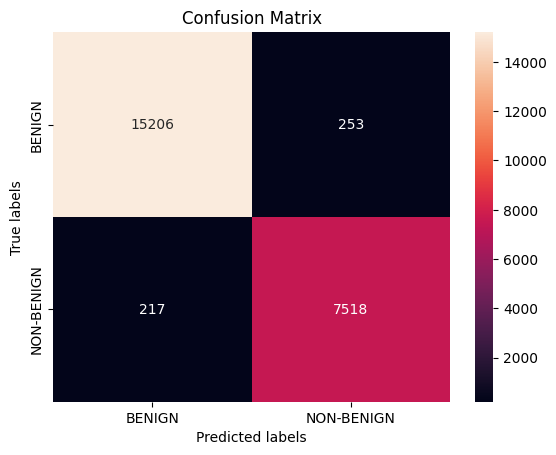

In [18]:
cm = confusion_matrix(y_valid,y_valid_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']); 
ax.yaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']);

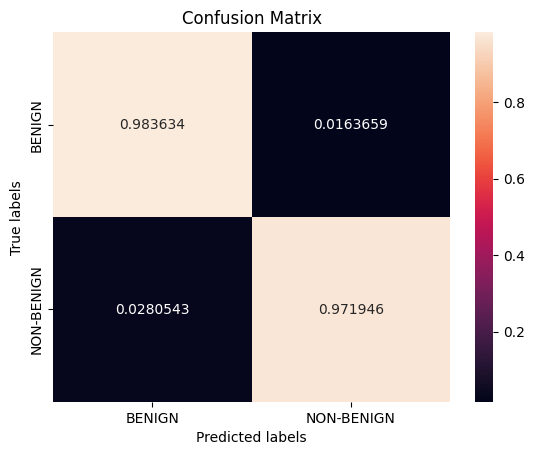

In [19]:
ax= plt.subplot()
sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']); 
ax.yaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']);

In [20]:
y_test_pred_prob = model.predict(test_dataset)

In [21]:
y_test_pred = np.array(y_test_pred_prob>0.5,dtype=np.int32)

In [22]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97     15459
         1.0       0.99      0.95      0.97     18466

    accuracy                           0.97     33925
   macro avg       0.97      0.97      0.97     33925
weighted avg       0.97      0.97      0.97     33925



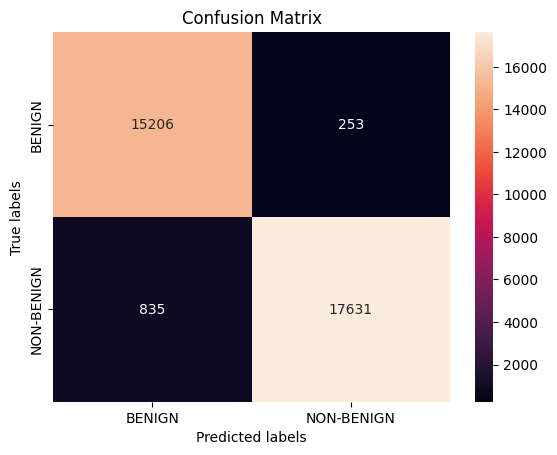

In [23]:
cm = confusion_matrix(y_test,y_test_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']); 
ax.yaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']);

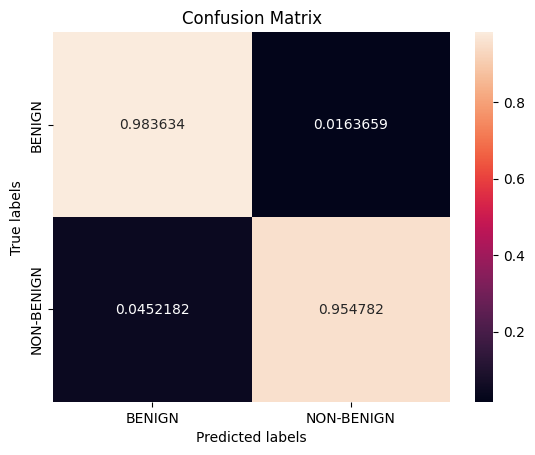

In [24]:
ax= plt.subplot()
sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']); 
ax.yaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']);

In [25]:
accuracy_score(y_test,y_test_pred),f1_score(y_test,y_test_pred)

(0.9679292557111275, 0.9700687757909215)